In [21]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn.functional import interpolate

import matplotlib.pyplot as plt
import numpy as np  

import Discriminator as disc
import Generator as gen
import SequentialGenerator as sg1
import prepData as prep
from collections import namedtuple

In [24]:
import torchvision.models as models
LossOutput = namedtuple("LossOutput", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])
# https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

In [25]:
vgg_model = models.vgg16(pretrained=True)
if torch.cuda.is_available():
    vgg_model.cuda()
loss_network = LossNetwork(vgg_model)
loss_network.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\monikaf/.cache\torch\checkpoints\vgg16-397923af.pth


LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

# AutoEncoder fuuuu
test out losses
Encoder
- input: 128 x 128
- output: 64 x 64 (or 32?)

Decoder
- input:  64 x 64
- output: 512 x 512 (or 32?)

**Work in progress**
Decoder ends up zeroing out the image somewhere after upscaling everytime.

In [2]:
batch_size = 5
N = 5
rank = 5

LR_dim = 128
HR_dim = 512
bottleneck_dim = 32


scalefactor = HR_dim/bottleneck_dim
downscalefactor = bottleneck_dim/LR_dim

### Load data

In [3]:
images=prep.load_images_from_folder('000001_01_01')
images=prep.normalize(images)
lowresimages=prep.compress_images(images)

In [4]:
len(images)

107

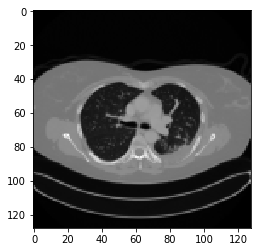

In [5]:
prep.show_img(lowresimages[19])

In [13]:
LR_loader = DataLoader(lowresimages[:20], batch_size=batch_size)#, pin_memory=cuda)
HR_loader = DataLoader(images[:20],batch_size=batch_size)#, pin_memory=cuda)

test_LR_loader = DataLoader(lowresimages[:-7], batch_size=batch_size)#, pin_memory=cuda)

### Model

In [14]:
class Autoencoder(torch.nn.Module):
    def __init__(self, layer):
        super(Autoencoder,self).__init__()

        self.encoder = gen.Generator(layer, N, rank, bottleneck_dim, bottleneck_dim, downscalefactor)
        self.decoder = gen.Generator(layer, N, rank, HR_dim, HR_dim, scalefactor)
        
        ## sequential generator
#         self.encoder = sg1.Generator(layer, N, rank, bottleneck_dim, bottleneck_dim, downscalefactor)
#         self.decoder = sg1.Generator(layer, N, rank, HR_dim, HR_dim, scalefactor)

    def forward(self, x):
        #print("Input shape = ", x.shape)
        #print(x.sum())
        x = self.encoder(x.float())
        #print("After encoder shape = ", x.shape)
        #print(x.sum())
        #prep.show_img(x[0][0].detach().numpy())        

        x = self.decoder(x)
        #print("After decoder shape = ", x.shape)
        #print(x.sum())
        return x

In [15]:
model = Autoencoder(gen.FTT_Layer)#.to(device)
#model = Autoencoder(sg1.FTT_Layer)
#model = Autoencoder(gen.PolyGAN_CP_Layer)

loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05) #weight_decay=1e-5,)

### Training

In [40]:
#CONTENT LOSS https://github.com/ceshine/fast-neural-style/blob/201707/style-transfer.ipynb

epoch_loss = []
num_epochs = 3

mse_loss = torch.nn.MSELoss()

model.train()
for epoch in range(num_epochs):
    model.train()
    #for img in LR_loader:
    for i, data in enumerate(zip(LR_loader, HR_loader)):
        batch_loss = []
        lr_img, hr_img = data
        
        img = Variable(lr_img.reshape(lr_img.shape[0], 1, LR_dim, LR_dim)).float()#.to(device)
        output = model(img).float()
        #hr_img = hr_img.reshape(hr_img.shape[0], 1, HR_dim, HR_dim).float()#.to(device)
        
        output = output.reshape(hr_img.shape[0], HR_dim, HR_dim)
        stacked_output = torch.stack((output,)*3, axis=1)
        stacked_hr = torch.stack((hr_img.float(),)*3, axis=1)
        
        features_output = loss_network(stacked_output)
        features_hr = loss_network(stacked_hr)
        
        f_xc_c = Variable(features_hr[1].data, requires_grad=False)
        content_loss = mse_loss(features_output[1], f_xc_c).float()
        
       # loss = loss_func(output, hr_img).float()
        optimizer.zero_grad()
        content_loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        
    epoch_loss.append(np.mean(batch_loss))
    print("completed epoch {}, mean loss {}".format(epoch+1,np.mean(batch_loss)))

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 754974720 bytes. Buy new RAM!


In [16]:
epoch_loss = []
num_epochs = 15

model.train()
for epoch in range(num_epochs):
    model.train()
    #for img in LR_loader:
    for i, data in enumerate(zip(LR_loader, HR_loader)):
        batch_loss = []
        lr_img, hr_img = data
        
        img = Variable(lr_img.reshape(lr_img.shape[0], 1, LR_dim, LR_dim)).float()#.to(device)
        output = model(img).float()

        hr_img = hr_img.reshape(hr_img.shape[0], 1, HR_dim, HR_dim).float()#.to(device)
        
        loss = loss_func(output, hr_img).float()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        
    epoch_loss.append(np.mean(batch_loss))
    print("completed epoch {}, mean loss {}".format(epoch+1,np.mean(batch_loss)))

completed epoch 1, mean loss 2.3664262672691727e+25
completed epoch 2, mean loss 1.2427986534199783e+25
completed epoch 3, mean loss 7.071959980879407e+24
completed epoch 4, mean loss 4.083730114974655e+24
completed epoch 5, mean loss 2.349553001641913e+24
completed epoch 6, mean loss 1.3364141502117974e+24
completed epoch 7, mean loss 7.480751358767857e+23
completed epoch 8, mean loss 4.1064433891913505e+23
completed epoch 9, mean loss 2.2075829321117692e+23
completed epoch 10, mean loss 1.1669728255162355e+23
completed epoch 11, mean loss 6.178316291283818e+22
completed epoch 12, mean loss 3.4349188545135396e+22
completed epoch 13, mean loss 2.1750454155959354e+22
completed epoch 14, mean loss 1.6732805785821441e+22
completed epoch 15, mean loss 1.5244079004499248e+22


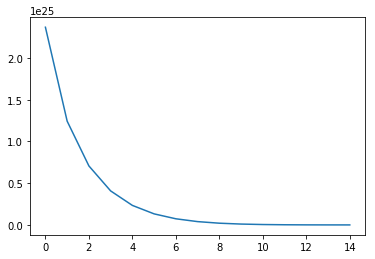

In [17]:
plt.plot(epoch_loss)
plt.show()

### Run test image through model

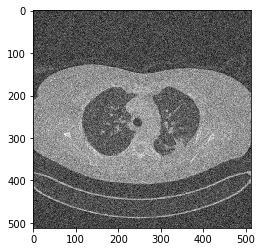

In [18]:
for img in test_LR_loader:
    img = Variable(img.reshape(img.shape[0], 1, LR_dim, LR_dim)).float()
    prep.show_img(model(img).detach().numpy()[0][0])
    break